<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/02_nice_with_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [146]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [147]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)


    def forward(self, x):
        x = x.view(len(x), -1,).to(torch.float32)
        return self.f(x)

    def coupling_layer(self, x, m, flow, forward=True):
        x = x.clone()

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a
        return z


    def f(self, x):
        z = x / torch.exp(self.s)

        for flow, model in enumerate(self.m, start=0):
            z = self.coupling_layer(z, model, flow, forward=True)

        log_det_j = torch.sum(self.s)

        return z, log_det_j

    def f_inv(self, z):

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            z = self.coupling_layer(z, model, flow,forward=False)

        x = z * torch.exp(self.s)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) - log_det_j).mean()
        return loss

In [148]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    stratify=digits.target,
                                                    test_size=0.25,
                                                   random_state=42)

X_train = (X_train - X_train.min()) / (X_train.max()-X_train.min())

train_data = Data(X_train)


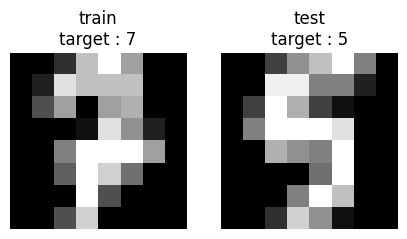

In [149]:
random_number = torch.randint(0,9,[1]).item()
image_train, category_train = X_train[random_number], y_train[random_number]
image_test, category_test = X_test[random_number], y_test[random_number]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((8,8)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((8,8)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [150]:
data_dim = 8*8

prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=256, num_flows=10)

train_loader = DataLoader(train_data, batch_size=250, shuffle=True)


In [151]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  116.19793319702148
Epoch :  2   -----------> Loss :  96.29167175292969
Epoch :  3   -----------> Loss :  86.27631378173828
Epoch :  4   -----------> Loss :  82.01253509521484
Epoch :  5   -----------> Loss :  78.33861923217773
Epoch :  6   -----------> Loss :  74.91670481363933
Epoch :  7   -----------> Loss :  71.51777776082356
Epoch :  8   -----------> Loss :  68.09712219238281
Epoch :  9   -----------> Loss :  64.67447598775227
Epoch :  10   -----------> Loss :  61.20541572570801
Epoch :  11   -----------> Loss :  57.72154108683268
Epoch :  12   -----------> Loss :  54.18929672241211
Epoch :  13   -----------> Loss :  50.62446212768555
Epoch :  14   -----------> Loss :  47.05975850423177
Epoch :  15   -----------> Loss :  43.672943115234375
Epoch :  16   -----------> Loss :  40.371344884236656
Epoch :  17   -----------> Loss :  36.93295033772787
Epoch :  18   -----------> Loss :  33.50097910563151
Epoch :  19   -----------> Loss :  30.24417177836100

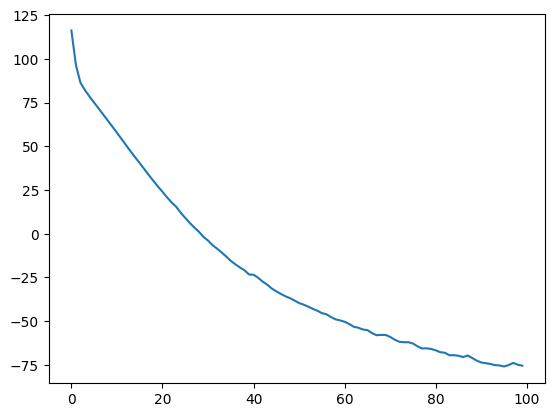

In [152]:
plt.plot(COST)

In [153]:
test = prior.sample((50,))
test

tensor([[-0.6050,  0.5547, -1.1679,  ..., -0.0777,  0.5033, -0.0326],
        [-1.1385, -0.0154, -0.0996,  ..., -0.2321,  0.1226,  0.5899],
        [-0.9043, -0.6764, -0.4857,  ..., -1.5881, -0.5619, -0.4025],
        ...,
        [-0.2547,  0.9953,  0.4673,  ...,  1.3196,  0.7040,  0.7046],
        [-0.1207, -0.9446,  0.0408,  ..., -0.4728,  0.5936, -0.2933],
        [-1.5469, -0.7977, -1.6828,  ..., -0.3313, -2.0464,  0.9397]])

In [154]:
sonuc = model.f_inv(test)
sonuc

tensor([[-3.6950e-03,  2.5130e-02,  2.8625e-01,  ...,  7.0255e-01,
          1.7752e-01,  4.2108e-03],
        [-2.8492e-03, -1.3961e-03, -1.2385e-01,  ...,  9.4573e-01,
          5.5031e-01,  1.6776e-02],
        [-1.7036e-03, -1.1067e-02,  5.7460e-01,  ..., -3.5302e-01,
         -1.3798e-01, -9.4373e-03],
        ...,
        [-2.7765e-03,  1.0629e-01,  7.1601e-01,  ...,  1.2812e+00,
          6.3242e-01,  8.9685e-02],
        [-2.3858e-04, -3.3016e-02,  4.2995e-01,  ...,  4.1797e-01,
          3.2554e-01, -2.0055e-02],
        [-3.9280e-03, -4.1583e-02, -1.1334e-01,  ...,  1.8987e-01,
         -1.7735e-01,  3.3489e-02]], grad_fn=<MulBackward0>)

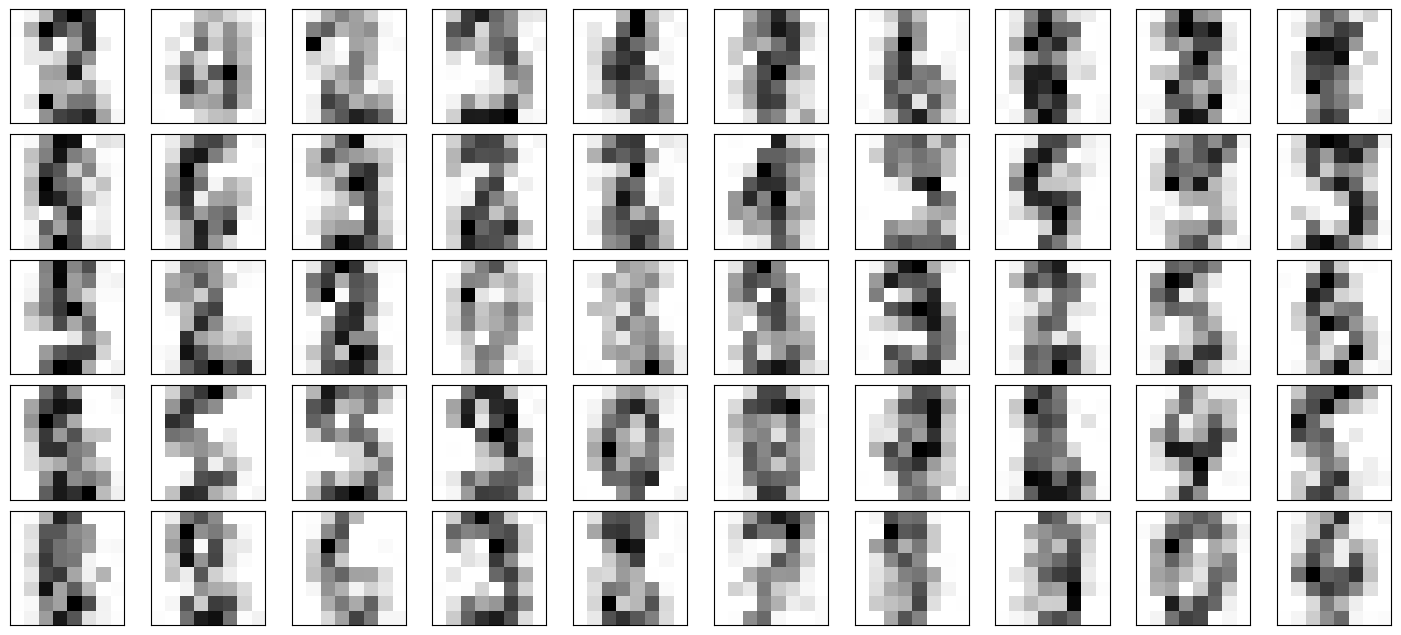

In [163]:
test = prior.sample((1797,))
sonuc = model.f_inv(test)

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow(torch.nn.ReLU()(sonuc[i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
    axs[1, i].imshow(torch.nn.ReLU()(sonuc[10+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
    axs[2, i].imshow(torch.nn.ReLU()(sonuc[20+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
    axs[3, i].imshow(torch.nn.ReLU()(sonuc[30+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
    axs[4, i].imshow(torch.nn.ReLU()(sonuc[40+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
fig.show()


In [156]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
#pca.fit(sonuc)

In [157]:
forward, logdet_j = model.forward(torch.tensor(X_test))
backward = model.f_inv(forward)

In [158]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(backward.detach().numpy())          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(450, 2)


In [159]:
projected_raw = pca.fit_transform(X_test)          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected_raw.shape)

(1797, 64)
(450, 2)


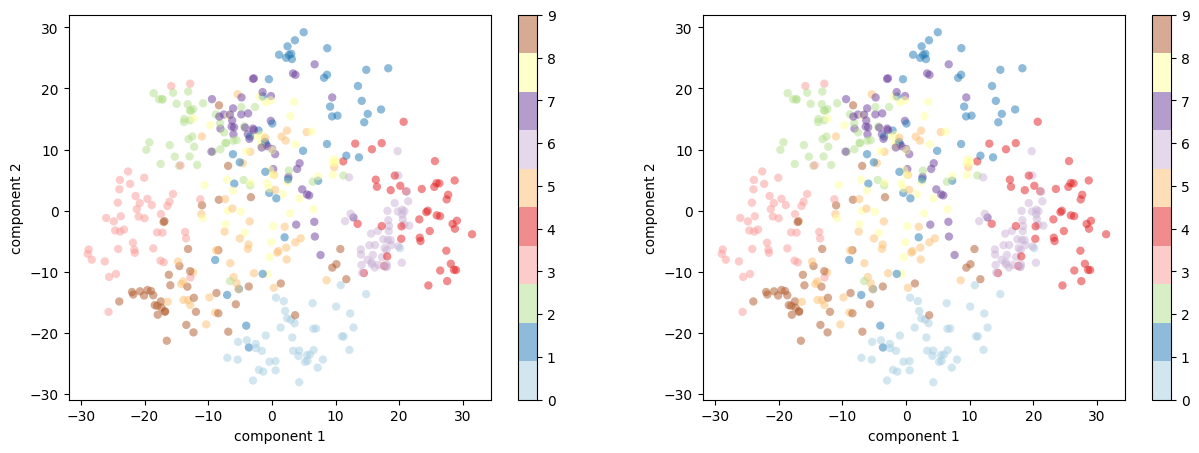

In [160]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1, 2, 1)
im1 = ax1.scatter(projected_raw[:, 0], projected_raw[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax1.set_xlabel('component 1')
ax1.set_ylabel('component 2')
plt.colorbar(im1, ax=ax1)

ax2 = fig.add_subplot(1, 2, 2)
im2 = ax2.scatter(projected[:, 0], projected[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax2.set_xlabel('component 1')
ax2.set_ylabel('component 2')
plt.colorbar(im2, ax=ax2)

plt.show()